In [51]:
subj = "Subj1"
exp = "exp_sep"

n_stages = [ 9, 8, 10 ][int(subj[-1:]) - 1]
scale = (exp != "reproduction")
scale = False

### Imports

In [52]:
%load_ext autoreload
%autoreload 2

import os

import SDA
import SDA.analytics
import SDA.clustquality
import SDA.stageprocess

import mne
import tqdm
import numpy
import pandas

pandas.set_option("display.precision", 2)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Data

In [53]:
data = mne.io.read_raw_fif(f"{subj}/src/data_rr_filt-raw.fif")
epochs = mne.read_epochs(f"{subj}/src/epochs_filt_rr-epo.fif")
df_features = pandas.read_feather(f"{subj}/{exp}/features.feather")
features = df_features.to_numpy()
print('Features: ', features.shape)

Opening raw data file Subj1/src/data_rr_filt-raw.fif...
    Range : 3500 ... 471000 =      7.000 ...   942.000 secs
Ready.
Reading d:\HSE\year-3\HSE\CourseProject\Subj1\src\epochs_filt_rr-epo.fif ...
    Found the data of interest:
        t =    -500.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
1046 matching events found
No baseline correction applied
0 projection items activated
Features:  (1046, 8)


In [54]:
if subj == "Subj2": # m8 (artifacts at the end)
    epochs = epochs[:-2]
    if exp != "reproduction": features = features[:-2]

### SDA

In [55]:
result, df_st_edges = SDA.SDA(scale = scale).apply(features)

Applying to 1046 samples with 8 features each
Running stage 1


  0%|          | 0/589 [00:00<?, ?it/s]

Running stage 2


  0%|          | 0/672 [00:00<?, ?it/s]

d:\Programs\Programming\Python\lib\site-packages\sklearn\base.py:1152: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


ValueError: cannot convert float NaN to integer

In [ ]:
if exp != "reproduction":
    edges_true = numpy.loadtxt(f"{subj}/reproduction/internal/best_edges.txt").astype(numpy.int32)
    print(edges_true)

    metrics = [ ]
    for row in  tqdm.tqdm(result['St_edges']):
        metrics.append(SDA.clustquality.cluster_metrics_ground(edges_true, row))
    result = pandas.concat([ result, pandas.DataFrame(metrics) ], axis = 1)

[   0   39  282  492  560  682  784  857  976 1046]


  0%|          | 0/2016 [00:00<?, ?it/s]

100%|██████████| 2016/2016 [00:06<00:00, 289.86it/s]


In [ ]:
result.to_csv(f"{subj}/{exp}/result.csv")
df_st_edges.to_csv(f"{subj}/{exp}/df_st_edges.csv")

### Analysis

In [ ]:
def analyze(result: pandas.DataFrame, key: str, folder: str):
    if not os.path.exists(f"{subj}/{exp}/{folder}"):
        os.makedirs(f"{subj}/{exp}/{folder}")

    results = SDA.analytics.best_results(result, key = key)
    results.to_csv(f"{subj}/{exp}/{folder}/results.csv")
    display(results)
    
    best_result = SDA.analytics.best_result(result, key = key, n_stages = n_stages)
    best_result_df = pandas.DataFrame([ best_result ])
    best_result_df.to_csv(f"{subj}/{exp}/{folder}/best_result.csv")
    display(best_result_df)
    
    best_edges = numpy.array(best_result['St_edges'])
    numpy.savetxt(f"{subj}/{exp}/{folder}/best_edges.txt", best_edges, fmt = "%d", newline = ' ')
    display(best_edges)

    edge_statistics = SDA.analytics.edge_statistics(features, best_edges)
    edge_statistics.to_csv(f"{subj}/{exp}/{folder}/edge_statistics.csv")
    display(edge_statistics)

    stage_timing = SDA.analytics.stage_timing(best_edges, epochs)
    stage_timing.to_csv(f"{subj}/{exp}/{folder}/stage_timing.csv")
    display(stage_timing)
    
    SDA.analytics.plot_stats(features, best_edges, epochs).savefig(f"{subj}/{exp}/{folder}/stats.svg")
    SDA.analytics.plot_features(df_features, best_edges).savefig(f"{subj}/{exp}/{folder}/features.svg")
    SDA.analytics.plot_eeg_stages(data, best_edges, epochs).savefig(f"{subj}/{exp}/{folder}/eeg_stages.svg")

#### Internal

,St_len_min,K_nb_max,N_cl_max,N_stages,Cl_cen,St_edges,Ward_dist,Cen_dist,Silh,Cal-Har,Dav-Bold,Avg-Silh,Avg-Cal-Har,Avg-Dav-Bold,AMI,ARI,FMI
0,0,40,20,3,Median,"[0, 223, 682, 1046]",4.56e+06,136.10,0.10,310.27,5.97,0.22,328.80,4.65,0.60,0.36,0.55
1,60,35,10,4,Median,"[0, 240, 671, 856, 1046]",3.98e+06,159.00,0.05,275.69,3.70,0.23,287.17,1.48,0.69,0.49,0.62
2,40,40,15,5,Median,"[0, 231, 556, 681, 856, 1046]",3.20e+06,177.55,0.04,284.55,2.41,0.33,288.37,1.09,0.78,0.62,0.71
3,40,35,10,6,Median,"[0, 187, 335, 556, 681, 856, 1046]",1.87e+06,147.59,0.01,250.86,2.43,0.27,174.66,1.31,0.77,0.59,0.65
4,0,35,15,7,Median,"[0, 187, 340, 556, 681, 856, 976, 1046]",1.95e+06,160.77,0.02,251.33,4.27,0.30,182.89,1.21,0.81,0.62,0.68
5,0,40,15,8,Median,"[0, 14, 187, 340, 556, 681, 855, 976, 1046]",1.65e+06,150.71,-0.03,218.93,4.03,0.27,155.19,1.27,0.81,0.63,0.68
6,0,45,15,9,Median,"[0, 14, 192, 340, 555, 681, 789, 856, 976, 1046]",1.21e+06,135.03,-0.05,193.99,4.56,0.24,116.64,1.76,0.83,0.67,0.72
7,0,40,10,10,Median,"[0, 14, 187, 246, 340, 556, 681, 789, 856, 976...",9.01e+05,120.52,-0.07,176.58,4.55,0.20,85.12,1.92,0.83,0.67,0.71
8,20,45,15,11,Median,"[0, 50, 187, 246, 340, 554, 609, 681, 789, 856...",6.81e+05,113.22,-0.09,165.34,4.13,0.19,64.44,1.99,0.82,0.64,0.69
9,0,40,10,12,Median,"[0, 14, 187, 246, 340, 556, 609, 681, 789, 855...",5.77e+05,112.71,-0.10,151.81,5.06,0.18,57.44,2.01,0.80,0.60,0.65


,St_len_min,K_nb_max,N_cl_max,N_stages,Cl_cen,St_edges,Ward_dist,Cen_dist,Silh,Cal-Har,Dav-Bold,Avg-Silh,Avg-Cal-Har,Avg-Dav-Bold,AMI,ARI,FMI
0,0,45,15,9,Median,"[0, 14, 192, 340, 555, 681, 789, 856, 976, 1046]",1.21e+06,135.03,-0.05,193.99,4.56,0.24,116.64,1.76,0.83,0.67,0.72


array([   0,   14,  192,  340,  555,  681,  789,  856,  976, 1046])

,Silh,Cal-Har,Dav-Bold,Ward,Centr
0,0.14,14.21,1.57,1.31e+05,100.29
1,0.32,216.81,1.09,1.94e+06,154.97
2,0.16,69.91,1.95,6.60e+05,86.80
3,0.25,133.92,1.31,1.39e+06,132.14
4,0.44,297.70,0.76,2.82e+06,220.22
5,0.04,4.88,5.15,4.77e+04,33.95
6,0.29,106.88,1.07,1.47e+06,185.14
7,0.27,88.79,1.20,1.23e+06,166.69


,0,1,2,3,4,5,6,7,8
"Start-end time, sec","(9.9, 22.7)","(23.5, 183.5)","(184.3, 316.3)","(317.1, 507.5)","(508.3, 619.5)","(620.3, 711.5)","(713.1, 770.7)","(771.5, 877.1)","(877.9, 938.7)"
"Time length, sec",12.8,160.0,132.0,190.4,111.2,91.2,57.6,105.6,60.8
Number of epochs,14,178,148,215,126,108,67,120,70


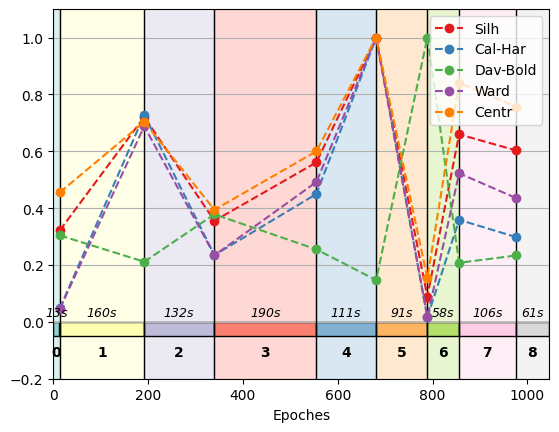

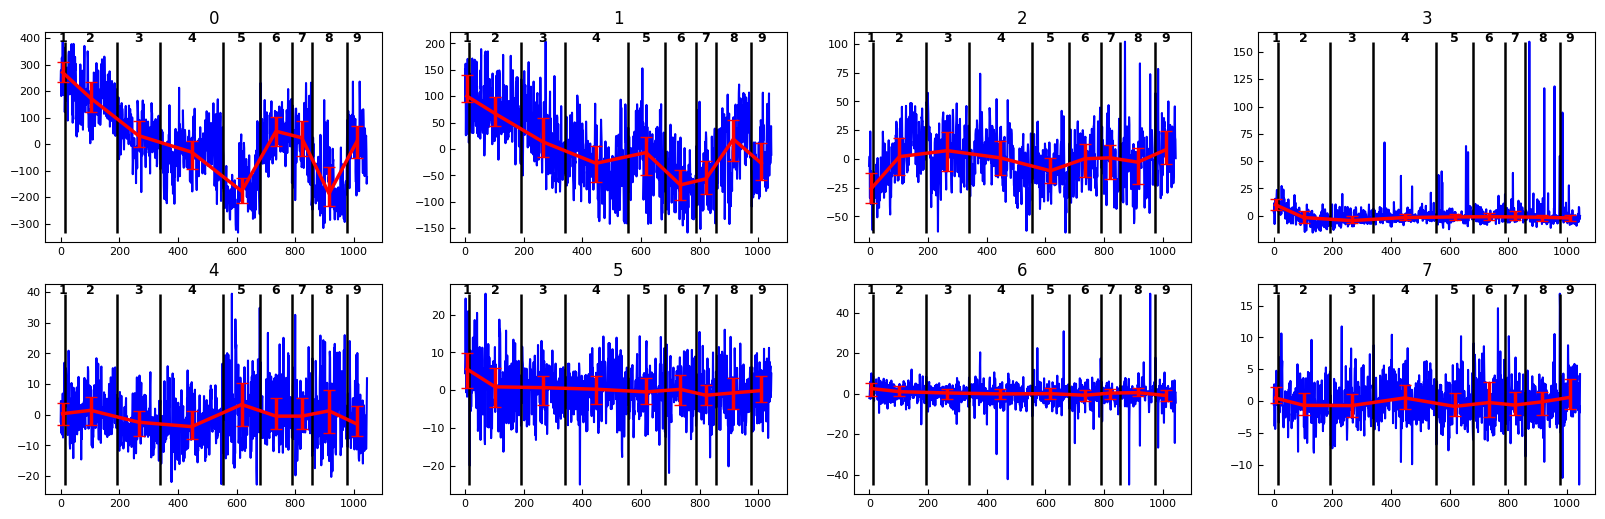

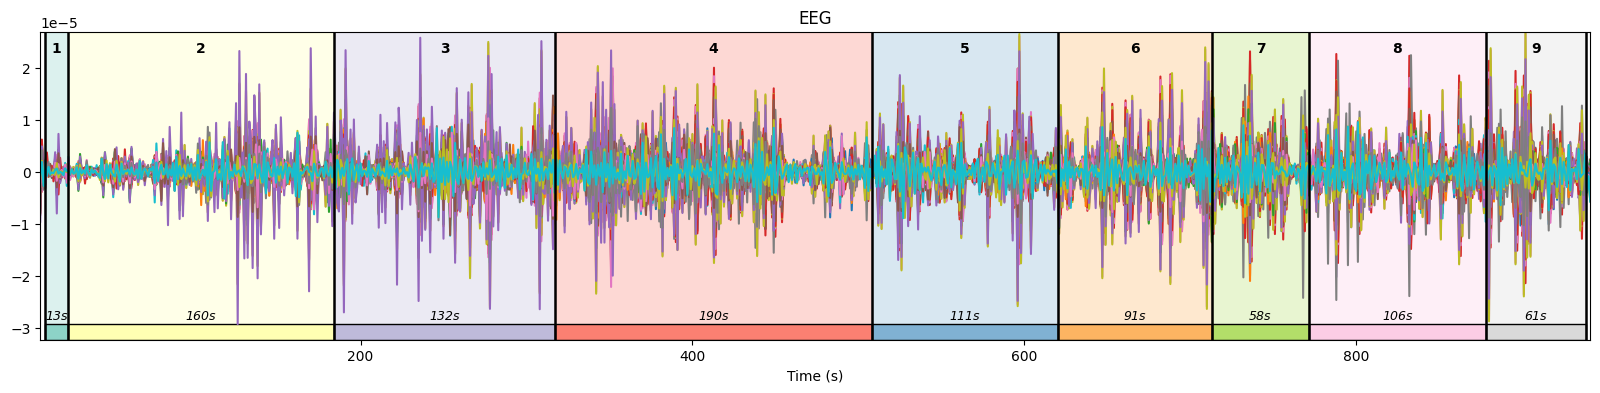

In [ ]:
analyze(result, 'Avg-Silh', "internal")
# [   0   39  282  492  560  682  784  857  976 1046]
# array([   0,   46,  210,  340,  554,  682,  784,  846,  975, 1046])

![Alternative Text][1707850881559]

[1707850881559]: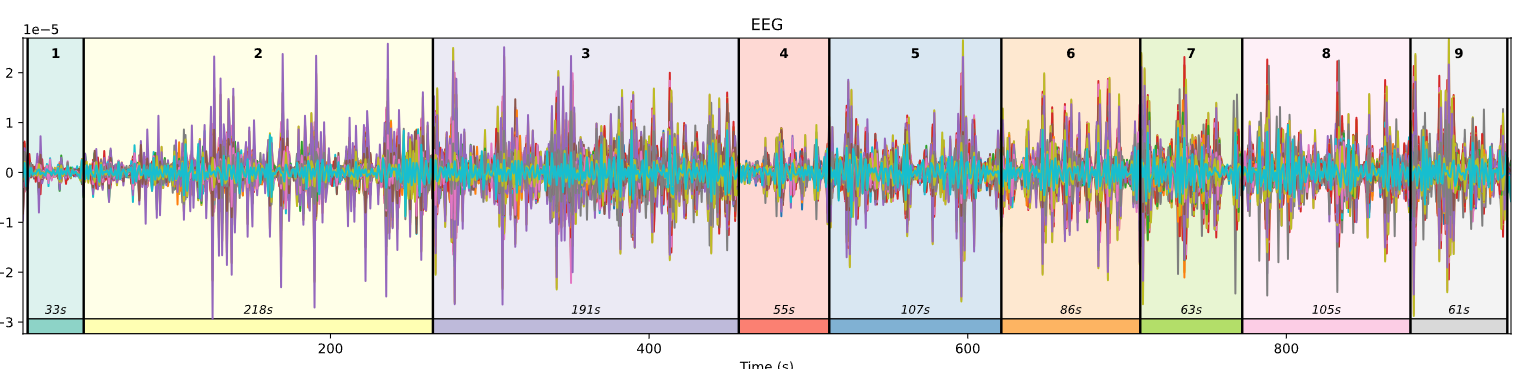

#### External

,St_len_min,K_nb_max,N_cl_max,N_stages,Cl_cen,St_edges,Ward_dist,Cen_dist,Silh,Cal-Har,Dav-Bold,Avg-Silh,Avg-Cal-Har,Avg-Dav-Bold,AMI,ARI,FMI
0,0,40,15,3,Mode,"[0, 340, 681, 1046]",4.30e+06,134.89,9.09e-02,271.81,3.48,0.19,283.52,2.77,0.62,0.42,0.58
1,0,45,15,4,Mode,"[0, 340, 554, 856, 1046]",1.53e+06,86.54,2.59e-02,185.88,6.65,0.11,108.88,5.28,0.71,0.54,0.65
2,0,50,15,5,Mode,"[0, 340, 554, 681, 856, 1046]",2.63e+06,164.82,2.48e-03,226.26,2.61,0.28,215.30,1.19,0.78,0.63,0.71
3,0,50,15,6,Mode,"[0, 246, 340, 554, 681, 856, 1046]",1.68e+06,140.95,2.06e-03,233.30,2.57,0.24,149.67,1.47,0.79,0.64,0.70
4,0,50,15,7,Mode,"[0, 246, 340, 554, 681, 856, 977, 1046]",1.78e+06,155.17,9.76e-03,233.39,4.79,0.28,160.96,1.33,0.82,0.69,0.74
5,0,50,15,8,Mode,"[0, 14, 246, 340, 554, 681, 856, 977, 1046]",1.54e+06,150.04,-4.60e-02,206.36,4.38,0.26,139.36,1.33,0.82,0.70,0.75
6,0,50,15,9,Mode,"[0, 14, 246, 340, 554, 681, 789, 856, 977, 1046]",1.11e+06,134.50,-6.46e-02,181.71,4.77,0.23,102.79,1.82,0.85,0.74,0.77
7,0,50,20,10,Mean,"[0, 41, 186, 244, 335, 560, 684, 786, 862, 973...",8.38e+05,115.48,-7.11e-02,166.74,4.69,0.20,75.51,1.94,0.85,0.68,0.73
8,0,50,20,11,Mean,"[0, 41, 186, 244, 335, 560, 684, 786, 854, 912...",7.09e+05,110.98,-8.53e-02,156.92,4.30,0.19,67.07,2.18,0.84,0.66,0.71
9,60,35,20,12,Mean,"[0, 184, 237, 306, 340, 514, 556, 681, 781, 85...",5.65e+05,100.12,-8.59e-02,143.18,6.07,0.16,53.85,3.42,0.82,0.65,0.70


,St_len_min,K_nb_max,N_cl_max,N_stages,Cl_cen,St_edges,Ward_dist,Cen_dist,Silh,Cal-Har,Dav-Bold,Avg-Silh,Avg-Cal-Har,Avg-Dav-Bold,AMI,ARI,FMI
0,0,50,15,9,Mode,"[0, 14, 246, 340, 554, 681, 789, 856, 977, 1046]",1.11e+06,134.5,-0.06,181.71,4.77,0.23,102.79,1.82,0.85,0.74,0.77


array([   0,   14,  246,  340,  554,  681,  789,  856,  977, 1046])

,Silh,Cal-Har,Dav-Bold,Ward,Centr
0,0.17,19.42,1.30,2.10e+05,126.24
1,0.28,151.19,1.12,1.54e+06,151.74
2,0.08,27.15,2.61,2.58e+05,62.89
3,0.24,131.22,1.33,1.37e+06,130.97
4,0.44,294.15,0.76,2.80e+06,219.08
5,0.04,4.88,5.15,4.77e+04,33.95
6,0.29,106.08,1.08,1.46e+06,184.31
7,0.27,88.24,1.20,1.22e+06,166.85


,0,1,2,3,4,5,6,7,8
"Start-end time, sec","(9.9, 22.7)","(23.5, 229.9)","(230.7, 316.3)","(317.1, 506.7)","(507.5, 619.5)","(620.3, 711.5)","(713.1, 770.7)","(771.5, 877.9)","(878.7, 938.7)"
"Time length, sec",12.8,206.4,85.6,189.6,112.0,91.2,57.6,106.4,60.0
Number of epochs,14,232,94,214,127,108,67,121,69


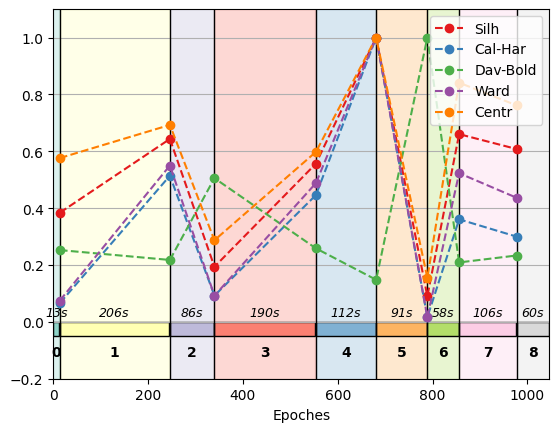

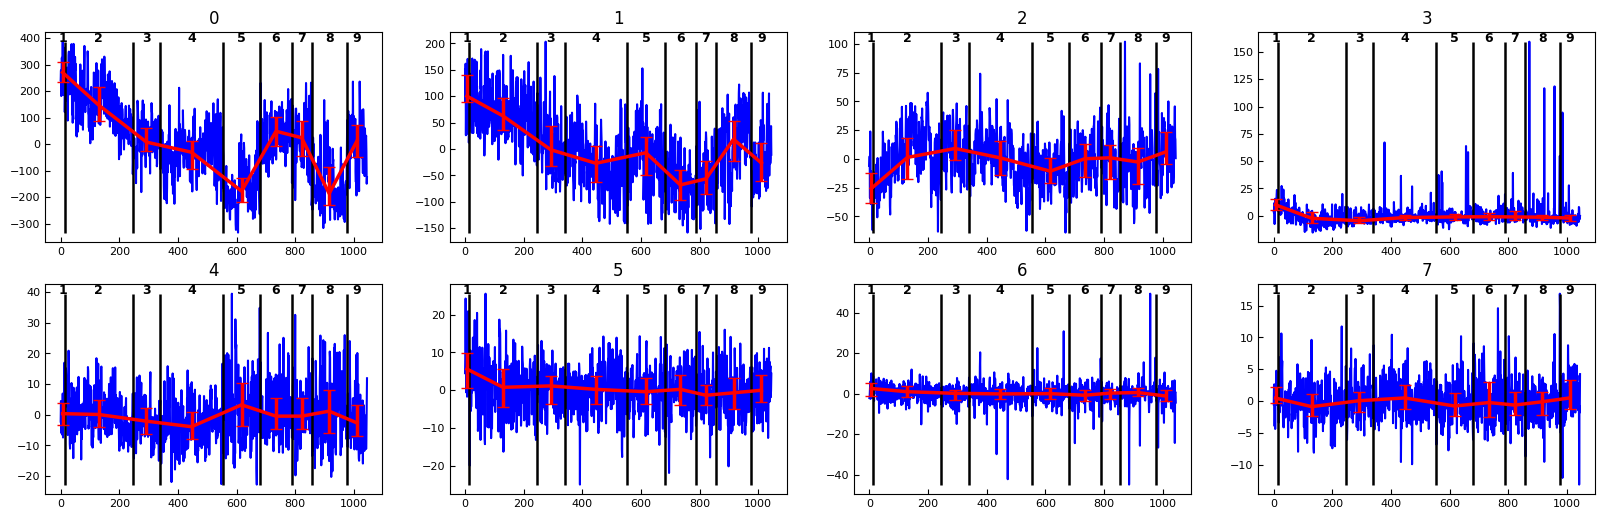

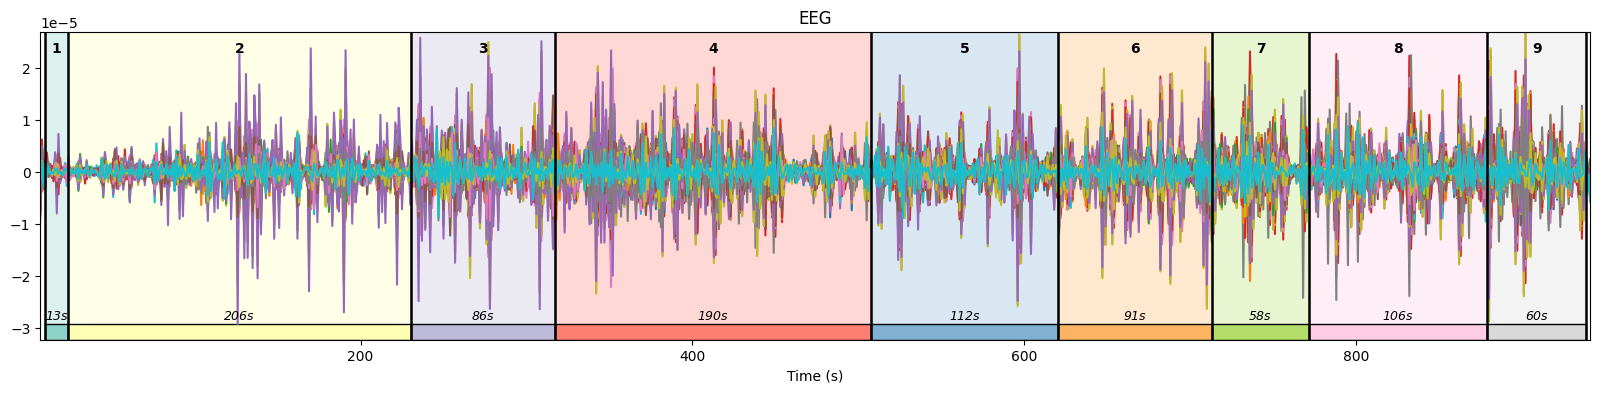

In [ ]:
if exp != "reproduction":
    analyze(result, 'FMI', "external")
# [   0   39  282  492  560  682  784  857  976 1046]

![Alternative Text][1707850881559]

[1707850881559]: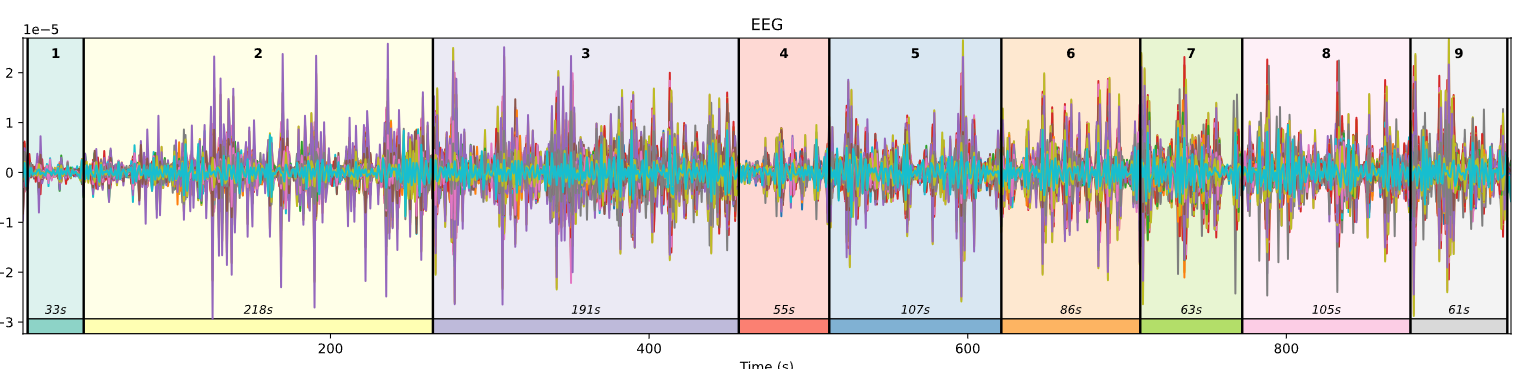